In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, Multiply, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_splitl
import matplotlib.pyplot as plt

In [ ]:
# paths
from google.colab import drive
drive.mount('/content/drive')
mri_folder = '/content/drive/MyDrive/MRI/mri'
mask_folder = '/content/drive/MyDrive/MRI/masks'

Mounted at /content/drive


In [ ]:
def load_images_and_masks(mri_folder, mask_folder, img_size=(256, 256)):
    mri_images = []
    mask_images = []

    for mri_filename in os.listdir(mri_folder):
        if mri_filename.endswith('.jpg'):
            mri_path = os.path.join(mri_folder, mri_filename)
            mask_path = os.path.join(mask_folder, mri_filename.replace('.jpg', '.png'))


            mri_img = load_img(mri_path, color_mode='grayscale', target_size=img_size)
            mri_img = img_to_array(mri_img) / 255.0


            mask_img = load_img(mask_path, color_mode='grayscale', target_size=img_size)
            mask_img = img_to_array(mask_img) / 255.0


            mask_img = (mask_img > 0.5).astype(np.float32)

            mri_images.append(mri_img)
            mask_images.append(mask_img)

    return np.array(mri_images), np.array(mask_images)

In [ ]:

mri_images, mask_images = load_images_and_masks(mri_folder, mask_folder)


X_train, X_val, y_train, y_val = train_test_split(mri_images, mask_images, test_size=0.2, random_state=42)

In [ ]:
def attention_gate(F_g, F_l, inter_channels):
    """
    F_g: result of upsampled layer
    F_l: Feature map from the skip connection.
    inter_channels: Intermediate number of channels.
    """
    # Transforming result of upsampled layer
    '''
    here, the simple difference between F_g and W_g is that we are reducing the number of channels in W_g for faster
    calculations and less computational load. say, if f_g had 512 channels, W_g will have 256 channels.
    '''
    W_g = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(F_g)
    W_g = BatchNormalization()(W_g)

    # Transforming feature map
    W_x = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(F_l)
    W_x = BatchNormalization()(W_x)

    # Adding the transformations, using relu to keep only the positive values
    psi = Activation('relu')(W_g + W_x)


    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(psi) #reducing the psi channels to 1
    psi = Activation('sigmoid')(psi) #converting values between 0s and 1s

    # Applying attention gate to the feature map. psi is the map having only relevant features, and hence, when applied to
    #the F_l, it will give us only the relevant features out of it.
    return Multiply()([F_l, psi])

In [ ]:
def attention_unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Downsample
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Upsample with Attention Gates
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    att6 = attention_gate(up6, drop4, inter_channels=512)
    merge6 = concatenate([att6, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    att7 = attention_gate(up7, conv3, inter_channels=256)
    merge7 = concatenate([att7, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    att8 = attention_gate(up8, conv2, inter_channels=128)
    merge8 = concatenate([att8, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    att9 = attention_gate(up9, conv1, inter_channels=64)
    merge9 = concatenate([att9, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, outputs)
    return model


model = attention_unet()

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])


In [ ]:
checkpoint = ModelCheckpoint('attention_unet_bce.h5', monitor='val_mean_io_u', mode='max', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_mean_io_u', mode='max', patience=10, restore_best_weights=True)

In [ ]:

#class_weights = {0: 1.0, 1: 10.0}
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=8,
                    #class_weight=class_weights,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.4705 - loss: 0.8607 - mean_io_u: 0.4988

60/60 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.4708 - loss: 0.8601 - mean_io_u: 0.4988 - val_accuracy: 0.0023 - val_loss: 0.7705 - val_mean_io_u: 0.4989
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 755ms/step - accuracy: 0.5188 - loss: 0.7420 - mean_io_u: 0.4988 - val_accuracy: 0.0132 - val_loss: 0.7201 - val_mean_io_u: 0.4989
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 739ms/step - accuracy: 0.5625 - loss: 0.7042 - mean_io_u: 0.4988 - val_accuracy: 0.0169 - val_loss: 0.7474 - val_mean_io_u: 0.4989
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 765ms/step - accuracy: 0.5876 - loss: 0.6900 - mean_io_u: 0.4987 - val_accuracy: 0.0284 - val_loss: 0.7601 - val_mean_io_u: 0.4989
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 767ms/step - accuracy: 0.6244 - loss: 0.6823 - mean_io_u: 0.4987 - val_accuracy: 0.0484 - val_loss: 0.7770 - val_mean_io_u: 0.4989
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 733ms/step - accuracy: 0.6613 - loss: 0.6762 - mean_io_u: 0.4989 - val_accuracy: 0.2711 - val_loss: 0.7346

60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 791ms/step - accuracy: 0.9037 - loss: 0.6296 - mean_io_u: 0.8200 - val_accuracy: 0.9884 - val_loss: 0.5742 - val_mean_io_u: 0.5443
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.9363 - loss: 0.6187 - mean_io_u: 0.8424

60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 778ms/step - accuracy: 0.9364 - loss: 0.6187 - mean_io_u: 0.8424 - val_accuracy: 0.9658 - val_loss: 0.5563 - val_mean_io_u: 0.6597
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.9519 - loss: 0.6129 - mean_io_u: 0.8520

60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 850ms/step - accuracy: 0.9519 - loss: 0.6129 - mean_io_u: 0.8520 - val_accuracy: 0.9586 - val_loss: 0.5657 - val_mean_io_u: 0.7350
Epoch 13/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9639 - loss: 0.6044 - mean_io_u: 0.8583

60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 885ms/step - accuracy: 0.9640 - loss: 0.6043 - mean_io_u: 0.8584 - val_accuracy: 0.9652 - val_loss: 0.5546 - val_mean_io_u: 0.8260
Epoch 14/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.9743 - loss: 0.5993 - mean_io_u: 0.8694

60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 877ms/step - accuracy: 0.9743 - loss: 0.5993 - mean_io_u: 0.8694 - val_accuracy: 0.9737 - val_loss: 0.5481 - val_mean_io_u: 0.8403
Epoch 15/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.9784 - loss: 0.5934 - mean_io_u: 0.8719

60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 969ms/step - accuracy: 0.9784 - loss: 0.5934 - mean_io_u: 0.8719 - val_accuracy: 0.9909 - val_loss: 0.5424 - val_mean_io_u: 0.8678
Epoch 16/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 70s 763ms/step - accuracy: 0.9849 - loss: 0.5876 - mean_io_u: 0.8802 - val_accuracy: 0.9941 - val_loss: 0.5429 - val_mean_io_u: 0.8665
Epoch 17/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.9874 - loss: 0.5854 - mean_io_u: 0.8816

60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 860ms/step - accuracy: 0.9874 - loss: 0.5854 - mean_io_u: 0.8816 - val_accuracy: 0.9950 - val_loss: 0.5408 - val_mean_io_u: 0.8706
Epoch 18/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 705ms/step - accuracy: 0.9895 - loss: 0.5824 - mean_io_u: 0.8834 - val_accuracy: 0.9952 - val_loss: 0.5355 - val_mean_io_u: 0.8598
Epoch 19/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9916 - loss: 0.5787 - mean_io_u: 0.8844

60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 892ms/step - accuracy: 0.9916 - loss: 0.5787 - mean_io_u: 0.8844 - val_accuracy: 0.9954 - val_loss: 0.5404 - val_mean_io_u: 0.8747
Epoch 20/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.9927 - loss: 0.5735 - mean_io_u: 0.8936

60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 858ms/step - accuracy: 0.9928 - loss: 0.5735 - mean_io_u: 0.8935 - val_accuracy: 0.9955 - val_loss: 0.5436 - val_mean_io_u: 0.8759
Epoch 21/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.9937 - loss: 0.5713 - mean_io_u: 0.8862

60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 860ms/step - accuracy: 0.9938 - loss: 0.5712 - mean_io_u: 0.8863 - val_accuracy: 0.9952 - val_loss: 0.5458 - val_mean_io_u: 0.8836
Epoch 22/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 762ms/step - accuracy: 0.9943 - loss: 0.5670 - mean_io_u: 0.8850 - val_accuracy: 0.9959 - val_loss: 0.5387 - val_mean_io_u: 0.8766
Epoch 23/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.9956 - loss: 0.5614 - mean_io_u: 0.8965

60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 868ms/step - accuracy: 0.9956 - loss: 0.5614 - mean_io_u: 0.8965 - val_accuracy: 0.9960 - val_loss: 0.5375 - val_mean_io_u: 0.8847
Epoch 24/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 763ms/step - accuracy: 0.9958 - loss: 0.5590 - mean_io_u: 0.8991 - val_accuracy: 0.9966 - val_loss: 0.5256 - val_mean_io_u: 0.8812
Epoch 25/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.9962 - loss: 0.5545 - mean_io_u: 0.8966

60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 874ms/step - accuracy: 0.9962 - loss: 0.5545 - mean_io_u: 0.8967 - val_accuracy: 0.9968 - val_loss: 0.5260 - val_mean_io_u: 0.8864
Epoch 26/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.9968 - loss: 0.5481 - mean_io_u: 0.9085

60/60 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9968 - loss: 0.5481 - mean_io_u: 0.9085 - val_accuracy: 0.9971 - val_loss: 0.5150 - val_mean_io_u: 0.8926
Epoch 27/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 762ms/step - accuracy: 0.9970 - loss: 0.5468 - mean_io_u: 0.9058 - val_accuracy: 0.9976 - val_loss: 0.5139 - val_mean_io_u: 0.8821
Epoch 28/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9973 - loss: 0.5420 - mean_io_u: 0.9045

60/60 ━━━━━━━━━━━━━━━━━━━━ 49s 826ms/step - accuracy: 0.9973 - loss: 0.5419 - mean_io_u: 0.9045 - val_accuracy: 0.9976 - val_loss: 0.5049 - val_mean_io_u: 0.9000
Epoch 29/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 736ms/step - accuracy: 0.9975 - loss: 0.5362 - mean_io_u: 0.9082 - val_accuracy: 0.9983 - val_loss: 0.4884 - val_mean_io_u: 0.8778
Epoch 30/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 760ms/step - accuracy: 0.9976 - loss: 0.5342 - mean_io_u: 0.9069 - val_accuracy: 0.9982 - val_loss: 0.4949 - val_mean_io_u: 0.8907


In [ ]:
loss, accuracy, mean_iou = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')
print(f'Validation Mean IoU: {mean_iou}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 84s 13s/step - accuracy: 0.9976 - loss: 0.5049 - mean_io_u: 0.9000
Validation Loss: 0.5048890709877014
Validation Accuracy: 0.9975999593734741
Validation Mean IoU: 0.900002121925354


In [ ]:
model.load_weights('attention_unet_bce.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


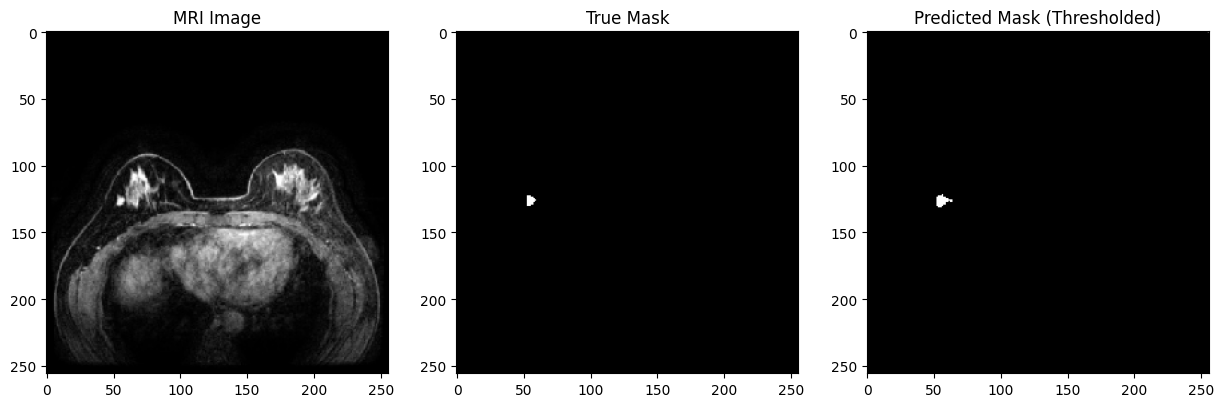

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


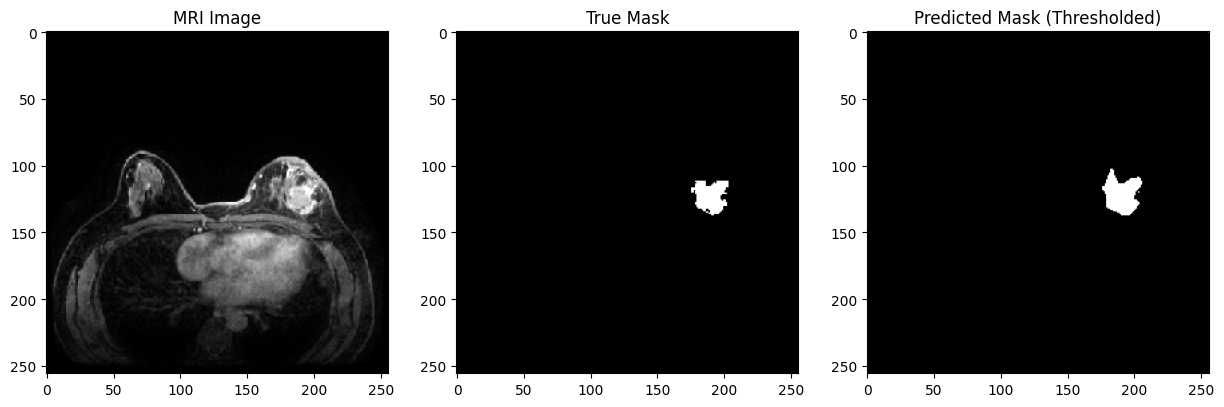

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


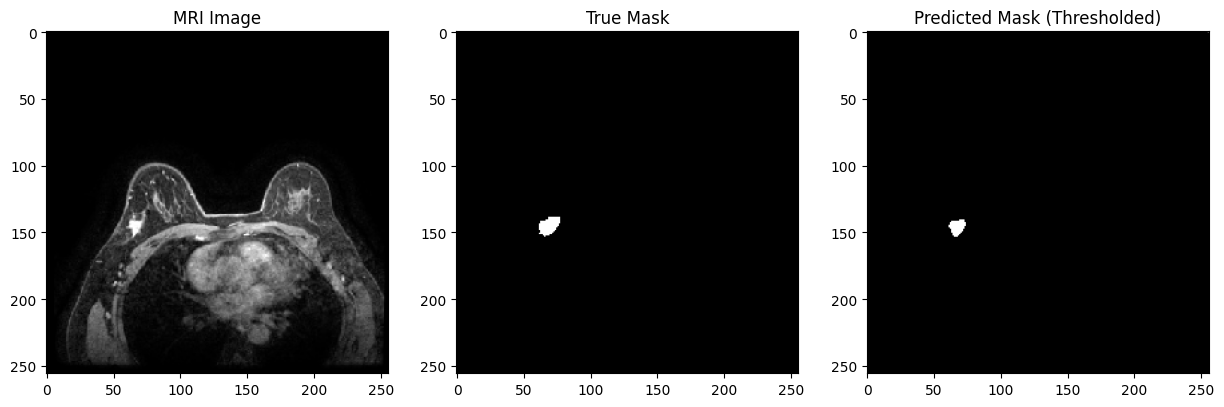

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


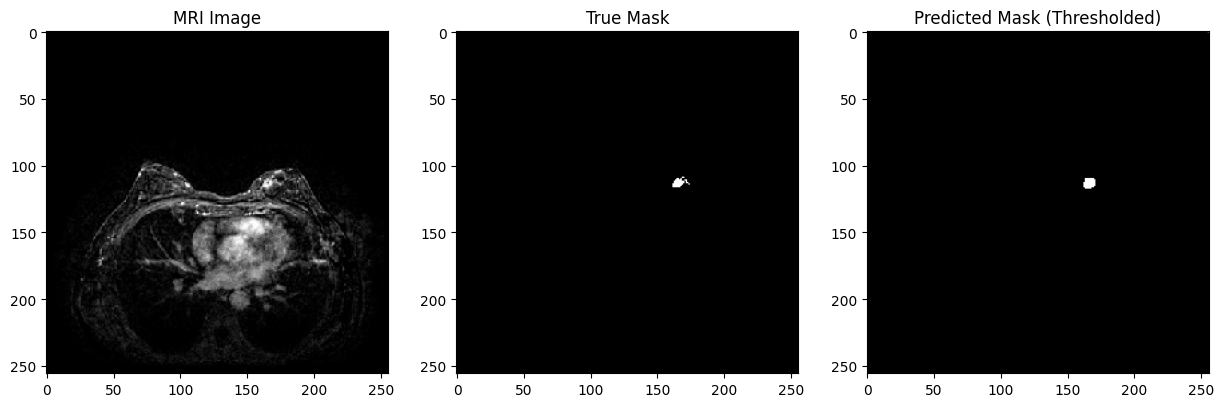

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


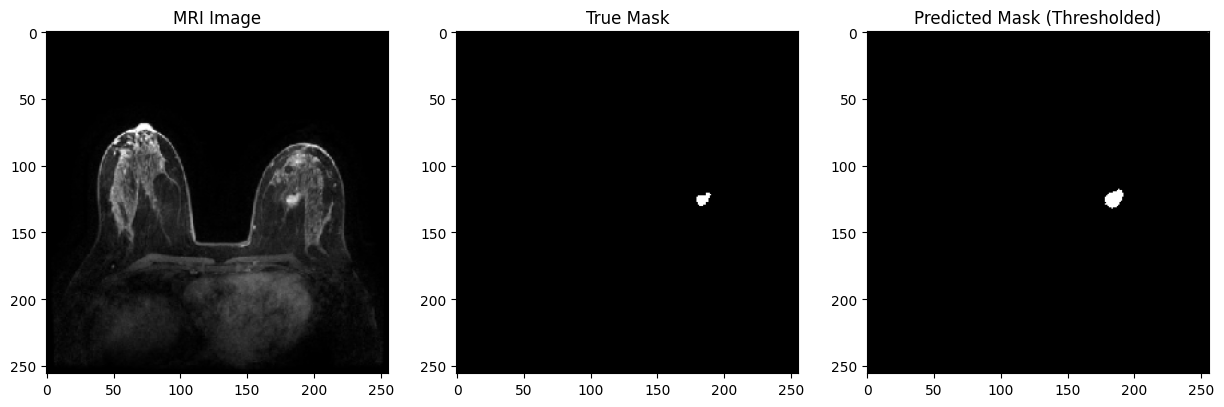

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


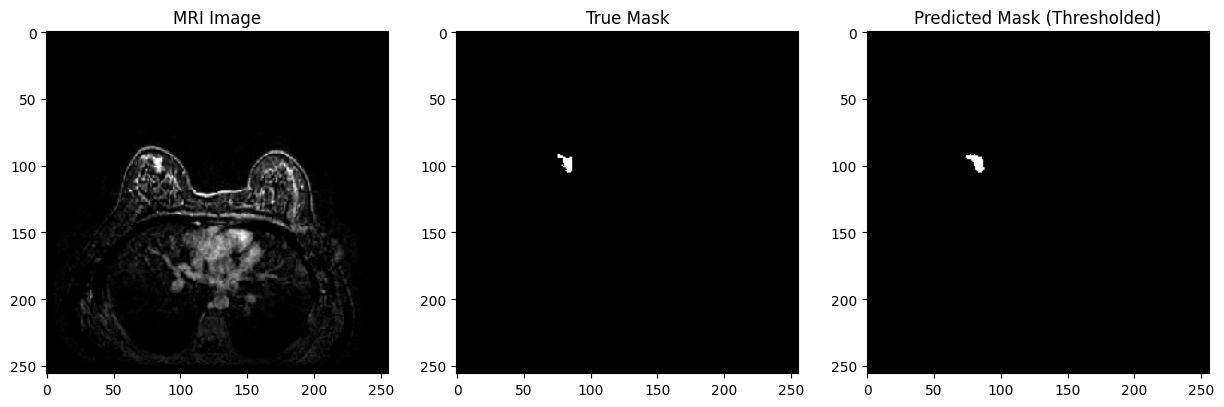

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


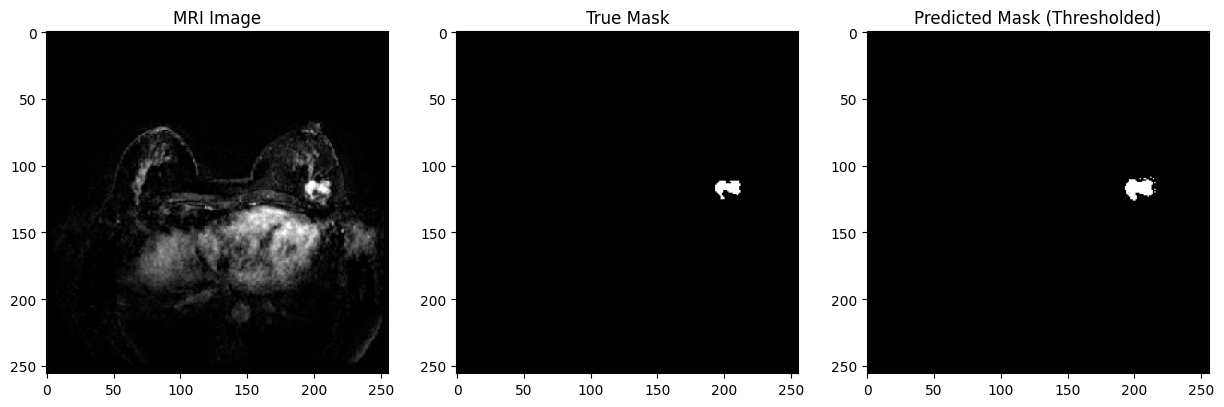

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


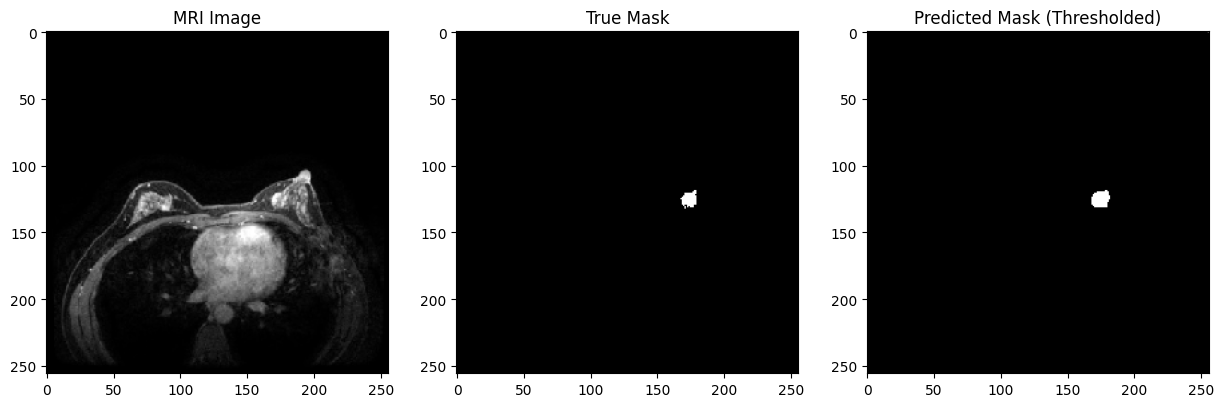

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


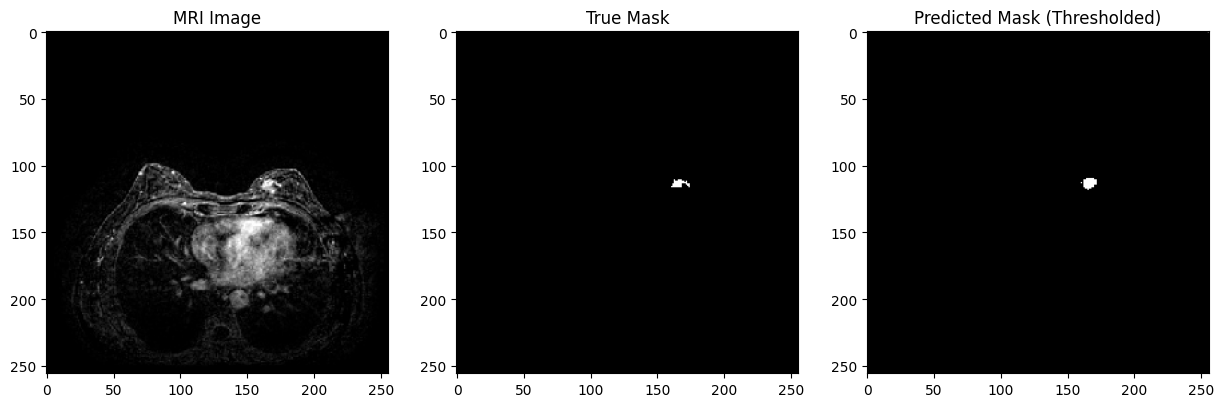

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


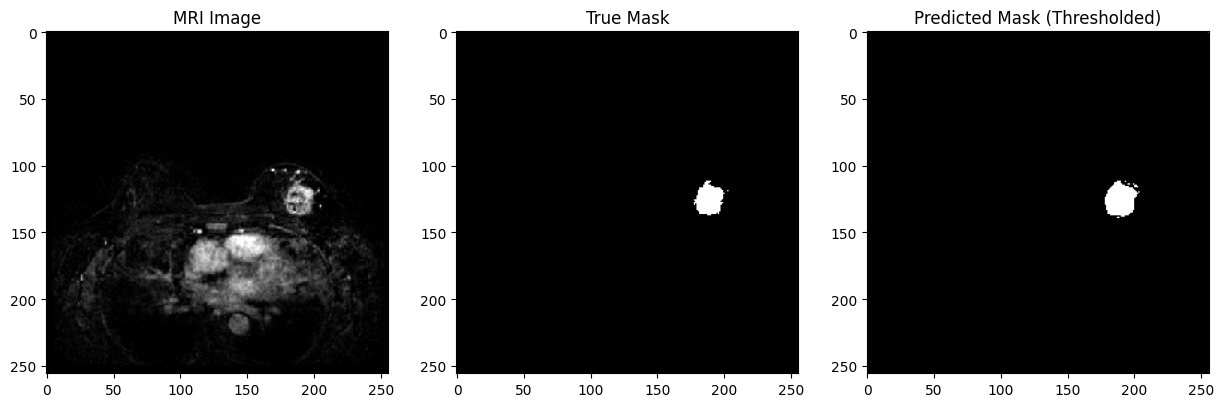

In [ ]:
def visualize_predictions(model, X_val, y_val, num_samples=10, threshold=0.7):
    for i in range(num_samples):
        sample_image = X_val[i]
        sample_mask = y_val[i]
        predicted_mask = model.predict(np.expand_dims(sample_image, axis=0))[0]
        predicted_mask_binary = (predicted_mask > threshold).astype(np.float32)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title('MRI Image')
        plt.imshow(sample_image.squeeze(), cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(sample_mask.squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask (Thresholded)')
        plt.imshow(predicted_mask_binary.squeeze(), cmap='gray')

        plt.show()

# Visualizing predictions
visualize_predictions(model, X_val, y_val)